#Load data

In [7]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
df = pd.read_pickle("/content/drive/My Drive/liveproject/mortgage_data_balanced.pkl.gz")

# Classify outcomes based on applicant income

In [9]:
import numpy as np

df[['log(applicant_income_000s)']] = np.log(df['applicant_income_000s'].copy())
pred_35 = df['log(applicant_income_000s)'].copy() > 3.5
pred_43 = df['log(applicant_income_000s)'].copy() > 4.3
pred_50 = df['log(applicant_income_000s)'].copy() > 5.0

assert(pred_35.sum() == 140608)
assert(pred_43.sum() == 70354)
assert(pred_50.sum() == 19405)

# Compute and chart classifier metrics

In [10]:
def accept_rate_group(group=None):
  def accept_rate(pred):
    def pred_group():
      return pred[group] if group is not None else pred
    return pred_group().mean() * 100
  return accept_rate

female = (df['applicant_sex_name'] == "Female").copy()
male = (df['applicant_sex_name'] == "Male").copy()

accept_rate = accept_rate_group()
accept_rate_male = accept_rate_group(male)
accept_rate_female = accept_rate_group(female)

## acceptance rate % across thresholds
### total
accept_rate_35 = accept_rate(pred_35)
accept_rate_43 = accept_rate(pred_43)
accept_rate_50 = accept_rate(pred_50)

### male
accept_rate_male_35 = accept_rate_male(pred_35)
accept_rate_male_43 = accept_rate_male(pred_43)
accept_rate_male_50 = accept_rate_male(pred_50)

### female
accept_rate_female_35 = accept_rate_female(pred_35) 
accept_rate_female_43 = accept_rate_female(pred_43) 
accept_rate_female_50 = accept_rate_female(pred_50) 

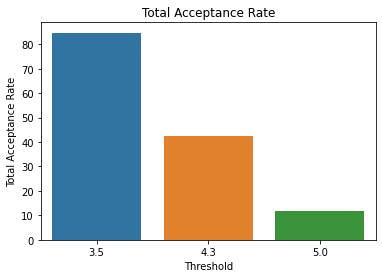

In [19]:
import seaborn as sns

# chart different thresholds: acceptance rates, disparate impact and 2-SD rule
d = pd.DataFrame({"Threshold": [3.5, 4.3, 5.0],
                  "Total Acceptance Rate": [accept_rate_35, accept_rate_43, accept_rate_50],
                  "Female Acceptance Rate": [accept_rate_female_35, accept_rate_female_43, accept_rate_female_50],
                  "Male Acceptance Rate": [accept_rate_male_35, accept_rate_male_43, accept_rate_male_50]})

sns.barplot(data=d, x="Threshold", y="Total Acceptance Rate").set_title('Total Acceptance Rate')
import matplotlib.pyplot as plt
plt.show()

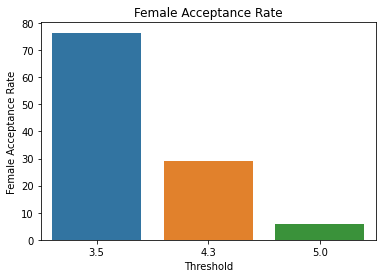

In [20]:
sns.barplot(data=d, x="Threshold", y="Female Acceptance Rate").set_title("Female Acceptance Rate")
plt.show()

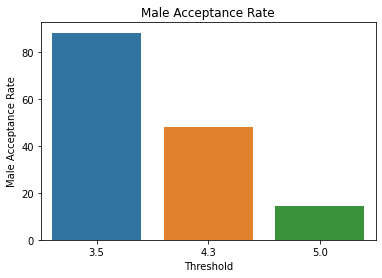

In [21]:
sns.barplot(data=d, x="Threshold", y="Male Acceptance Rate").set_title("Male Acceptance Rate")
plt.show()

# Compute and chart the Disparate Impact metric

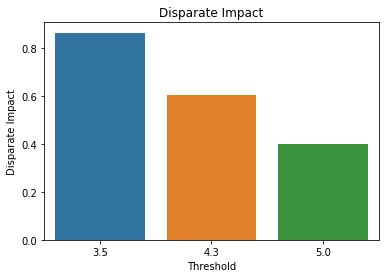

In [77]:
def DispImpact(pred, group_a, group_b):
  ### Disparate Impact
  SR_A = pred[group_a==1].mean() # success rate group A
  SR_B = pred[group_b==1].mean() # success rate group B
  return SR_A/SR_B

## disparate impact across thresholds
DP_35 = DispImpact(pred_35, female, male)
DP_43 = DispImpact(pred_43, female, male)
DP_50 = DispImpact(pred_50, female, male)

from math import isclose

assert(isclose(DP_35, 0.864, rel_tol=0.001))
assert(isclose(DP_43, 0.605, rel_tol=0.001))
assert(isclose(DP_50, 0.3996, rel_tol=0.001))

d = pd.DataFrame({"Threshold": [3.5, 4.3, 5.0],
                  "Disparate Impact": [DP_35, DP_43, DP_50]})

sns.barplot(data=d, x="Threshold", y="Disparate Impact").set_title("Disparate Impact")
plt.show()

# Compute and chart the 2-SD Rule Metric

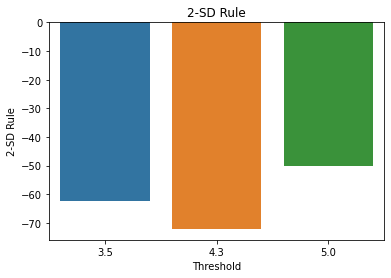

In [87]:
def TwoSDRule(pred, group_a, group_b):
    import numpy as np

    ### 2-SD Rule
    SR_A = pred[group_a==1].mean() # success rate group A
    SR_B = pred[group_b==1].mean() # success rate group B
    SR_T = pred.mean() # success rate total
    P_min = (group_a==1).mean() # minority proportion - usually group A
    N = len(pred) # sample size
    return (SR_A - SR_B)/np.sqrt( (SR_T * (1.0 - SR_T))/(N * P_min * (1 - P_min)))

## 2-SD rule across thresholds
Z_35 = TwoSDRule(pred_35, female, male)
Z_43 = TwoSDRule(pred_43, female, male)
Z_50 = TwoSDRule(pred_50, female, male)

assert(isclose(Z_35, -62.3, rel_tol=0.001))
assert(isclose(Z_43, -72.3, rel_tol=0.001))
assert(isclose(Z_50, -50.2, rel_tol=0.001))

d = pd.DataFrame({"Threshold": [3.5, 4.3, 5.0],
                  "2-SD Rule": [Z_35, Z_43, Z_50]})

sns.barplot(data=d, x="Threshold", y="2-SD Rule").set_title("2-SD Rule")
plt.show()